In [20]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np # For handling image data for plotting

# --- Configuration ---
INPUT_DIM = 28 * 28
HIDDEN_DIM_1 = 128
HIDDEN_DIM_2 = 64
ENCODING_DIM = 32
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS_AE = 10
EPOCHS_DAE = 15
NOISE_FACTOR = 0.4

# --- Objective 1: Modified Autoencoder Architecture ---

# Define the modified Autoencoder class with an extra hidden layer
class AutoencoderWithExtraLayer(nn.Module):
    def __init__(self):
        super(AutoencoderWithExtraLayer, self).__init__()

        # --- Encoder ---
        # Original Input -> Hidden 1 -> Hidden 2 (New) -> Encoding
        self.encoder = nn.Sequential(
            nn.Linear(INPUT_DIM, HIDDEN_DIM_1),
            nn.ReLU(True),
            nn.Linear(HIDDEN_DIM_1, HIDDEN_DIM_2), # New hidden layer
            nn.ReLU(True),
            nn.Linear(HIDDEN_DIM_2, ENCODING_DIM),
            nn.ReLU(True) # Or remove ReLU for latent space if needed
        )

        # --- Decoder ---
        # Encoding -> Hidden 2 (New) -> Hidden 1 -> Original Output
        self.decoder = nn.Sequential(
            nn.Linear(ENCODING_DIM, HIDDEN_DIM_2), # Decode to new hidden layer size
            nn.ReLU(True),
            nn.Linear(HIDDEN_DIM_2, HIDDEN_DIM_1),
            nn.ReLU(True),
            nn.Linear(HIDDEN_DIM_1, INPUT_DIM),
            nn.Sigmoid() # Use Sigmoid for output pixels (0-1 range)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# --- Architecture Overview ---
#
# **Modified Autoencoder Architecture**
#
# The original autoencoder likely had a structure like:
# Input -> Hidden Layer 1 -> Encoding -> Hidden Layer 1 -> Output
#
# We have added an additional hidden layer (Hidden Layer 2) to both the encoder and decoder:
#
# **Encoder:**
# Input (784 nodes) -> Linear(784, 128) -> ReLU -> Linear(128, 64) -> ReLU -> Linear(64, 32) -> ReLU -> Encoding (32 nodes)
#
# **Decoder:**
# Encoding (32 nodes) -> Linear(32, 64) -> ReLU -> Linear(64, 128) -> ReLU -> Linear(128, 784) -> Sigmoid -> Output (784 nodes)
#
# **Diagrammatic Representation:**
#
# [Input Layer (784)] ==> [Hidden Layer 1 (128)] ==> [Hidden Layer 2 (64)] ==> [Encoding Layer (32)] ==> [Hidden Layer 2 (64)] ==> [Hidden Layer 1 (128)] ==> [Output Layer (784)]
#       (Encoder Part)                                      (Decoder Part)
#
# This deeper architecture allows the model to potentially learn more complex hierarchical features of the input data.


In [18]:
# --- Function to Plot Loss (Objective 4)---
def plot_loss(loss_history, title="Training Loss"):
    """Plots the training loss per epoch."""
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.grid(True)
    plt.show()

In [21]:
# --- Noise Function (for DAE) ---
def add_noise(inputs, noise_factor=NOISE_FACTOR):
    noisy = inputs + noise_factor * torch.randn_like(inputs)
    noisy = torch.clamp(noisy, 0., 1.)
    return noisy

In [22]:
# --- Data Loading and Preparation ---

# MNIST Dataset Transformation
transform = transforms.Compose([
    transforms.ToTensor(), # Converts PIL image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    # transforms.Normalize((0.5,), (0.5,)) # Optional: Normalize if needed, adjust Sigmoid in decoder if used
])

# Download and load the training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
# --- Model Initialization and Training Setup ---

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Standard Autoencoder Section (Objective 1 & 2 & 4) ---

print("\n=== Training Standard Autoencoder ===")

# Initialize Model
model_ae = AutoencoderWithExtraLayer().to(device)

# Display Architecture (Text Image)
print("\n--- Standard Autoencoder Architecture ---")
print(model_ae)
print("---------------------------------------\n")

# Loss and Optimizer
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(model_ae.parameters(), lr=LEARNING_RATE)

Using device: cpu

=== Training Standard Autoencoder ===

--- Standard Autoencoder Architecture ---
AutoencoderWithExtraLayer(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
---------------------------------------



Starting Training...
Epoch [1/10], Average Loss: 0.0614
Epoch [2/10], Average Loss: 0.0333
Epoch [3/10], Average Loss: 0.0273
Epoch [4/10], Average Loss: 0.0242
Epoch [5/10], Average Loss: 0.0221
Epoch [6/10], Average Loss: 0.0205
Epoch [7/10], Average Loss: 0.0194
Epoch [8/10], Average Loss: 0.0183
Epoch [9/10], Average Loss: 0.0174
Epoch [10/10], Average Loss: 0.0168
Training Finished.


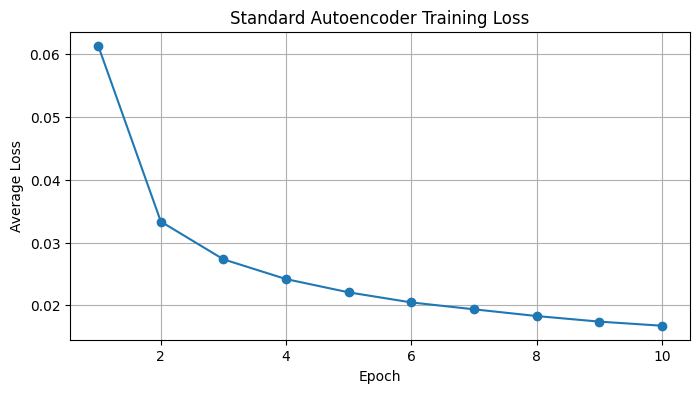

In [24]:
# Training Loop for Standard Autoencoder
def train_standard_ae(model, loader, criterion, optimizer, epochs, device):
    model.train()
    loss_history = [] # For Objective 4
    for epoch in range(epochs):
        total_loss = 0
        for data in loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device) # Flatten and send to device

            # Forward pass
            output = model(img)
            loss = criterion(output, img) # Compare output with original clean image

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        loss_history.append(avg_loss) # Store loss for plotting
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')
    return loss_history

# Train the model
print("Starting Training...")
# Train the Standard AE
ae_loss_history = train_standard_ae(model_ae, train_loader, criterion_ae, optimizer_ae, EPOCHS_AE, device)
print("Training Finished.")

# Plot Standard AE Loss (Objective 4)
plot_loss(ae_loss_history, title="Standard Autoencoder Training Loss")


Visualizing Standard AE results...

Standard AE: Original vs Reconstructed (Top: Original, Bottom: Reconstructed)


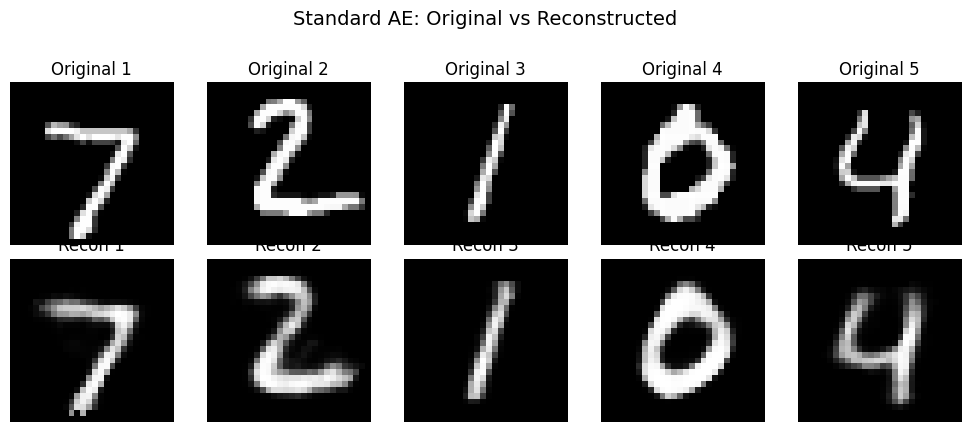


Visualizing Single Image (Index: 0) - Standard AE


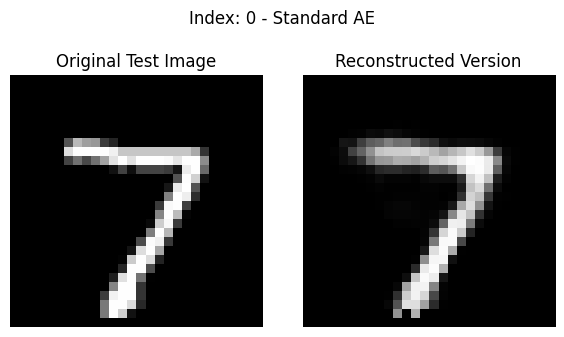


Visualizing Single Image (Index: 15) - Standard AE


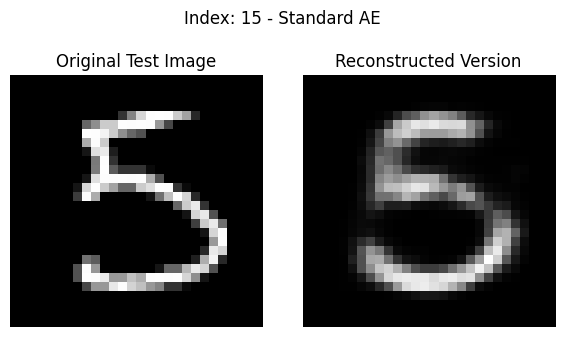

In [25]:
# --- Visualization Functions---

# Function to visualize original vs reconstructed images (batch)
def visualize_reconstruction(model, data_loader, device, num_images=5, title="Original vs Reconstructed"):
    """Visualizes original vs reconstructed images from a data loader."""
    model.eval()
    data_iter = iter(data_loader)
    images, _ = next(data_iter)

    images_subset = images[:num_images] # Select subset
    # For standard AE, the input to model is the clean image
    # For DAE, we'll handle noise addition before calling the model below
    images_flat = images_subset.view(images_subset.size(0), -1).to(device)

    # Handle potential DAE case: If model is DAE, input should be noisy
    # We check the title or could pass a flag, here using title for simplicity
    if "Denoising" in title:
         print("Applying noise for DAE visualization...")
         images_flat = add_noise(images_flat, NOISE_FACTOR) # Add noise to input for DAE
         # The 'original' display will now be the noisy input for DAE
         original_display_images = images_flat.cpu().view(images_subset.size(0), 1, 28, 28).numpy()
         plot_title_original = "Noisy Input"
    else:
         original_display_images = images_subset.numpy() # Use clean images for standard AE display
         plot_title_original = "Original"


    # Get reconstructions
    with torch.no_grad():
        reconstructed_flat = model(images_flat) # Pass potentially noisy (for DAE) or clean (for AE) input

    # Reshape images back to 28x28
    reconstructed_images = reconstructed_flat.cpu().view(images_subset.size(0), 1, 28, 28).numpy()

    # Plotting
    print(f"\n{title} (Top: {plot_title_original}, Bottom: Reconstructed)")
    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(num_images * 2, 4.5))
    fig.suptitle(title, fontsize=14)

    for i in range(num_images):
        # Plot Original / Noisy Input
        ax = axes[0, i]
        ax.imshow(np.squeeze(original_display_images[i]), cmap='gray')
        ax.set_title(f"{plot_title_original} {i+1}")
        ax.axis('off')

        # Plot Reconstructed
        ax = axes[1, i]
        ax.imshow(np.squeeze(reconstructed_images[i]), cmap='gray')
        ax.set_title(f"Recon {i+1}")
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Visualize one specific image if needed (by index)
def visualize_single_image(model, dataset, device, index=0, is_denoising=False, title="Original vs Reconstructed"):
    """Visualizes a single image (original/noisy vs reconstructed) by index."""
    model.eval()
    image, _ = dataset[index] # Get specific image

    # Handle potential DAE case
    if is_denoising:
        print(f"Applying noise for single DAE visualization (Index: {index})...")
        image_flat = image.view(1, -1).to(device)
        image_input_flat = add_noise(image_flat, NOISE_FACTOR) # Add noise
        original_display_image = image_input_flat.cpu().view(1, 28, 28).numpy().squeeze()
        plot_title_original = "Noisy Input"
    else:
        image_input_flat = image.view(1, -1).to(device) # Use clean image for standard AE
        original_display_image = image.numpy().squeeze()
        plot_title_original = "Original Test Image"

    with torch.no_grad():
        reconstructed_flat = model(image_input_flat) # Pass potentially noisy (DAE) or clean (AE) input

    reconstructed_image = reconstructed_flat.cpu().view(1, 28, 28).numpy().squeeze()

    print(f"\nVisualizing Single Image (Index: {index}) - {title}")
    fig, axes = plt.subplots(1, 2, figsize=(6, 3.5))
    fig.suptitle(f"Index: {index} - {title}", fontsize=12)

    # Original / Noisy Input
    axes[0].imshow(original_display_image, cmap='gray')
    axes[0].set_title(plot_title_original)
    axes[0].axis('off')

    # Reconstructed
    axes[1].imshow(reconstructed_image, cmap='gray')
    axes[1].set_title("Reconstructed Version")
    axes[1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()


# Visualize Standard AE Results (Objective 2 - Using User's Functions)
print("\nVisualizing Standard AE results...")
visualize_reconstruction(model_ae, test_loader, device, num_images=5, title="Standard AE: Original vs Reconstructed")
visualize_single_image(model_ae, test_dataset, device, index=0, is_denoising=False, title="Standard AE")
visualize_single_image(model_ae, test_dataset, device, index=15, is_denoising=False, title="Standard AE")

In [26]:
# --- Denoising Autoencoder Section (Objective 3 & 4) ---

print("\n=== Training Denoising Autoencoder ===")
model_dae = AutoencoderWithExtraLayer().to(device)
print("\n--- Denoising Autoencoder Architecture ---")
print(model_dae)
print("----------------------------------------\n")
criterion_dae = nn.MSELoss()
optimizer_dae = optim.Adam(model_dae.parameters(), lr=LEARNING_RATE)


=== Training Denoising Autoencoder ===

--- Denoising Autoencoder Architecture ---
AutoencoderWithExtraLayer(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
----------------------------------------



Starting Training...
Epoch [1/15], Average DAE Loss: 0.0680
Epoch [2/15], Average DAE Loss: 0.0432
Epoch [3/15], Average DAE Loss: 0.0334
Epoch [4/15], Average DAE Loss: 0.0299
Epoch [5/15], Average DAE Loss: 0.0276
Epoch [6/15], Average DAE Loss: 0.0256
Epoch [7/15], Average DAE Loss: 0.0243
Epoch [8/15], Average DAE Loss: 0.0233
Epoch [9/15], Average DAE Loss: 0.0225
Epoch [10/15], Average DAE Loss: 0.0217
Epoch [11/15], Average DAE Loss: 0.0211
Epoch [12/15], Average DAE Loss: 0.0205
Epoch [13/15], Average DAE Loss: 0.0200
Epoch [14/15], Average DAE Loss: 0.0196
Epoch [15/15], Average DAE Loss: 0.0194
Training Finished.


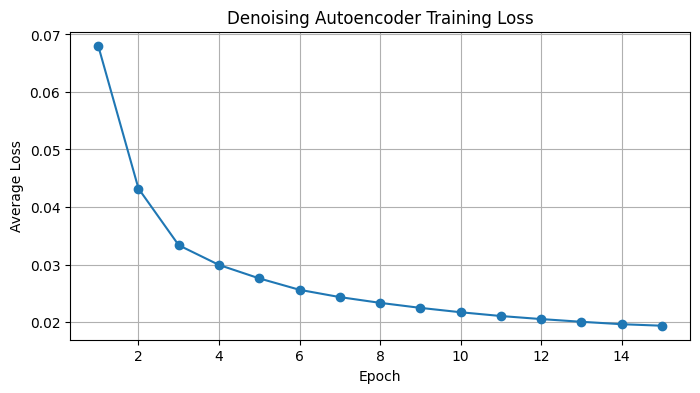

In [27]:
# (Training loop 'train_denoising_ae' remains the same as previous version)
def train_denoising_ae(model, loader, criterion, optimizer, epochs, device, noise_factor):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        total_loss = 0
        for data in loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)
            noisy_img = add_noise(img, noise_factor)
            output = model(noisy_img)
            loss = criterion(output, img) # Loss vs clean image
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        loss_history.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Average DAE Loss: {avg_loss:.4f}')
    return loss_history

# Train the model
print("Starting Training...")
dae_loss_history = train_denoising_ae(model_dae, train_loader, criterion_dae, optimizer_dae, EPOCHS_DAE, device, NOISE_FACTOR)
print("Training Finished.")

plot_loss(dae_loss_history, title="Denoising Autoencoder Training Loss")


Visualizing Denoising AE results...
Applying noise for DAE visualization...

Denoising AE: Noisy Input vs Reconstructed (Top: Noisy Input, Bottom: Reconstructed)


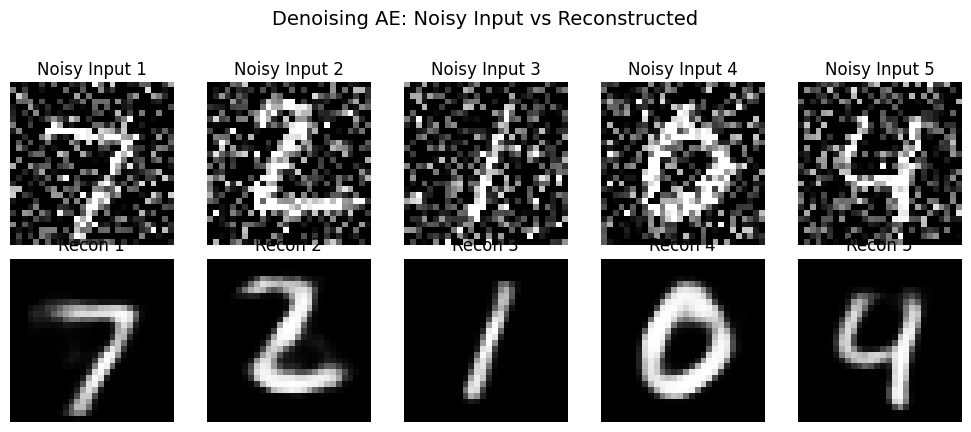

Applying noise for single DAE visualization (Index: 5)...

Visualizing Single Image (Index: 5) - Denoising AE


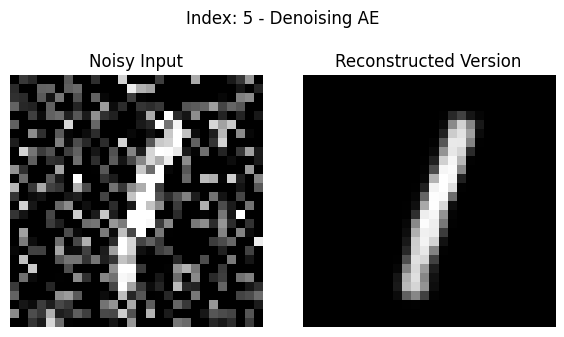

Applying noise for single DAE visualization (Index: 25)...

Visualizing Single Image (Index: 25) - Denoising AE


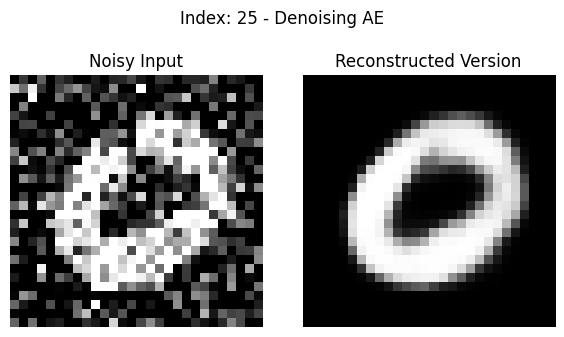

In [28]:
# Visualize Denoising AE Results (Objective 3 - Using User's Functions, Adapted)
# NOTE: We adapt the calls to show Noisy Input vs. Reconstruction
print("\nVisualizing Denoising AE results...")
visualize_reconstruction(model_dae, test_loader, device, num_images=5, title="Denoising AE: Noisy Input vs Reconstructed")
visualize_single_image(model_dae, test_dataset, device, index=5, is_denoising=True, title="Denoising AE")
visualize_single_image(model_dae, test_dataset, device, index=25, is_denoising=True, title="Denoising AE")